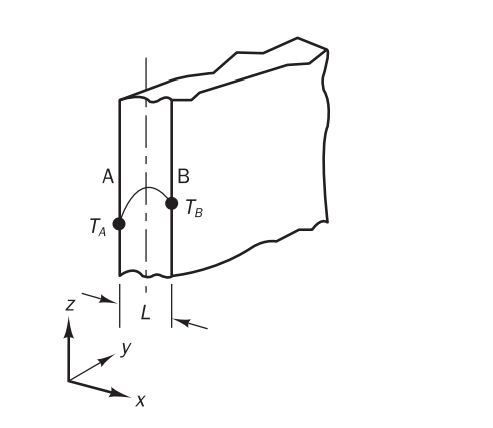

**Problema 4.2)** Considere a placa metálica acima, de espessura L = 2, Área A = 1, com condutividade térmica = 0.5 e geração uniforme de calor **q = 1000**. Faces A e B estão na temperatura de 100 e 200 graus celsius.
Considere que nas direções y e z são grandes o suficiente para dizer que o gradiente de temperatura nelas é desprezível. Sendo assim, a equação governante do problema é dada por:

\begin{equation}
    \frac{d}{dx} \frac{d(\kappa T)}{dx} + q = 0
\end{equation}

### Modelagem

Integrando a equação sobre um volume de controle:

\begin{equation}
    \int_{\Delta V}^{} \frac{d}{dx} \frac{d(\kappa T)}{dx} + \int_{\Delta V}^{} q = 0
\end{equation}

O termo fonte será tratando considerando o elemento pequeno suficiente para que uma interpolação linear seja utilizada. Assim, o mesmo pode ser avaliado pegando uma média: $\bar S \Delta V = q \Delta V$.
Portanto:

\begin{equation}
    \left[  \left( \kappa_e A_e \frac{T_E - T_P}{\delta x_e} \right) \right] + \left[  \left( \kappa_w A_w \frac{T_P - T_W}{\delta x_w} \right) \right] + qA\delta x = 0
\end{equation}

Podemos rearranjar a equação anterior e botá-la também em uma forma geral do tipo:

\begin{equation}
    a_P T_P = a_W T_W + a_E T_E + S_U
\end{equation}

onde:

$a_W: \kappa A / \delta x$

$a_E: \kappa A / \delta x$

$a_P: a_W + a_E - S_p$

$S_P: 0$

$S_u: qA\delta x$

In [26]:
import numpy as np
import matplotlib.pyplot as plt

In [27]:
kappa = 0.5 # Coeficiente de difusão
S = 1 # Área da seção transversal
q = 1e6 # Transferência de calor do termo fonte (!!!)
N = 1000 # Número de pontos da discretização
L = 0.02 # Comprimento da barra metálica
Ta = 100 # Temperatura em x = 0
Tb = 200 # Temperatura em x = L

h = np.float64(L / (N)) # Tamanho do intervalo discretizado

In [28]:
# coeficientes da matriz A
def coeff_A(i):
    if i == 0 :
        # condição de contorno Ta
        aW = 0
        aE = (kappa*S)/h
        Sp = (-2*kappa*S)/h
        aP = aW + aE - Sp
        Su = (2*kappa*S*Ta)/h + q*S*h # adição do termo fonte (!!!)
    elif i == N-1:
        # condição de contorno Tb
        aW = (kappa*S)/h
        aE = 0
        Sp = (-2*kappa*S)/h
        aP = aW + aE - Sp
        Su = (2*kappa*S*Tb)/h + q*S*h
    else:
        aW = (kappa*S)/h
        aE = (kappa*S)/h
        Sp = 0
        aP = aW + aE
        Su = q*S*h
    return aW, aE, aP, Su

# Constroi a matriz A e b para resolver o sistema: Au=b.
def build_A_and_b():
    A = np.zeros((N,N))
    b = np.zeros((N,1))

    # Calcula antecipadamente condições de contorno...
    aW, aE, aP, Su = coeff_A(0)
    A[0,0] = aP
    A[0,1] = -aE 
    b[0] = Su

    aW, aE, aP, Su = coeff_A(N-1)
    A[N-1,N-1] = aP
    A[N-1,N-2] = -aW 
    b[N-1] = Su

    # ordem Ap, Ae, Aw
    for i in range(1,N-1):
        aW, aE, aP, Su = coeff_A(i) # encontra os coeficientes para preencher a matriz
        A[i,i] = aP
        A[i,i+1] = -aE 
        A[i,i-1] = -aW
        b[i] = Su

    return A, b

In [29]:
A, b = build_A_and_b()
# print(A)
# print(b)
u_middle = np.linalg.solve(A, b) # obtém a temperatura no interior
u = np.zeros(N+2) # vetor para armazenar os pontos interiores e as condições de contorno
u[1:-1] = u_middle[:, 0] #interior
u[0] = Ta #contorno left
u[-1] = Tb #contorno right

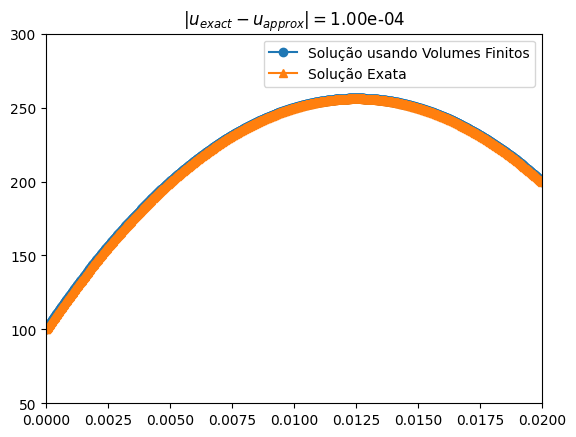

In [30]:
# Plotando os resultados...
middle_points = np.arange(h/2, h/2 + (N)*h, h)
x = np.zeros(N+2)
x[1:-1] = middle_points
x[0] = 0.0
x[-1] = L

def exact(x):
    return ((Tb - Ta)/L + q*(L-x)/(2*kappa))*x + Ta

# calculo do erro
error = np.linalg.norm(u - exact(x), np.inf)

plt.plot(x, u, marker='o', label='Solução usando Volumes Finitos')
plt.plot(x, exact(x), marker='^', label='Solução Exata')
plt.xlim(0, 0.02)
plt.ylim(50, 300)
plt.legend()
plt.title(r"$| u_{exact} - u_{approx} | = $" + f"{error:.2e}")
plt.show()